# CS146 Assignment 2
### Yuhao Chen

## Question 1. Call center data modeling

### Import data using code from 2.2 class

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


### Define useful functions using code from 2.2 class

In [2]:
# The detailed description for this code is in 2.2 class, link: 
# https://cocalc.com/projects/814c43a3-c5f7-451d-9c2b-b6d7526af040/files/Class%202.2%20%7C%20168441320.ipynb?session=default

# Define the prior distribution(gamma distribution)
def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

# Define the likelihood function with exponential distribution
def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

# Define the function to calculate the posterior probability with likelihood function, prior distribution, and data
def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

# Define the function to calculate the percentile from the ditribution
def compute_percentile(parameter_values, distribution_values, percentile):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

### Calculate the posterior distributions

In [3]:
# Set the range of lambda and create an empty list to store the result of posteriors
lambdas = np.linspace(0.01,24,600)
pos_list=[]

# Calculat the posterior distribution for each hour
for calls in  waiting_times_per_hour:
    posterior = compute_posterior(lambdas, prior, likelihood, calls)
    pos_list.append(posterior)

### Plot the posterior distributions

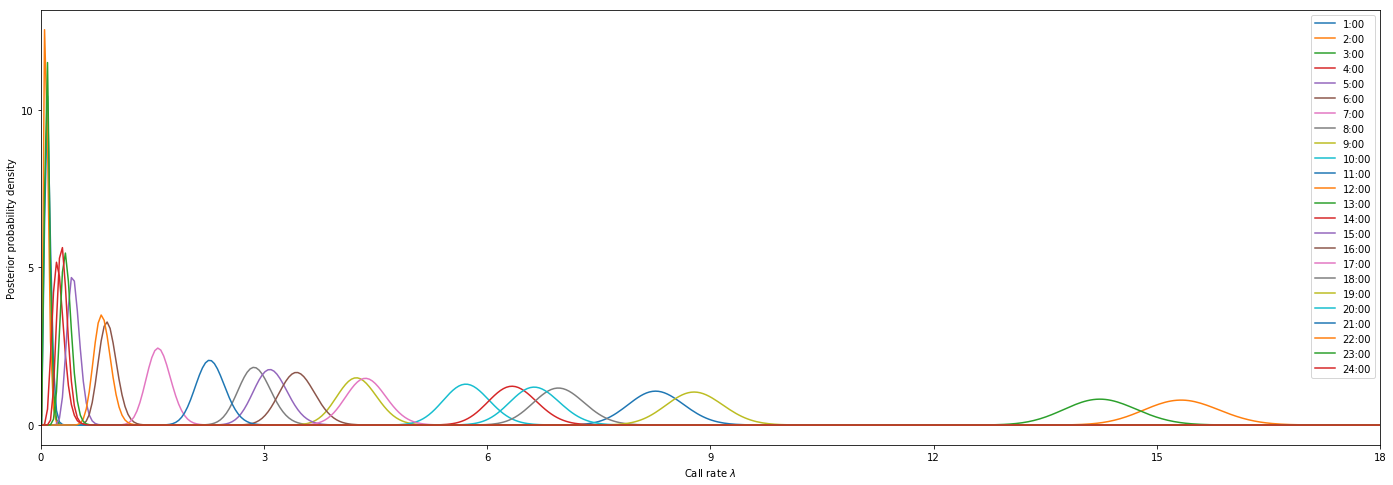

In [4]:
# Show the posteriors in a plot
plt.figure(figsize=(24,8))
for i in range(24):
    plt.plot(lambdas,pos_list[i],label=str(i+1)+":00")
plt.xticks(np.arange(0,20,3))
plt.yticks(np.arange(0,14,5))
plt.xlim(0,18)
plt.xlabel("Call rate $\lambda$")
plt.ylabel("Posterior probability density")
plt.legend(loc="best")
plt.show()

### Result Presentation

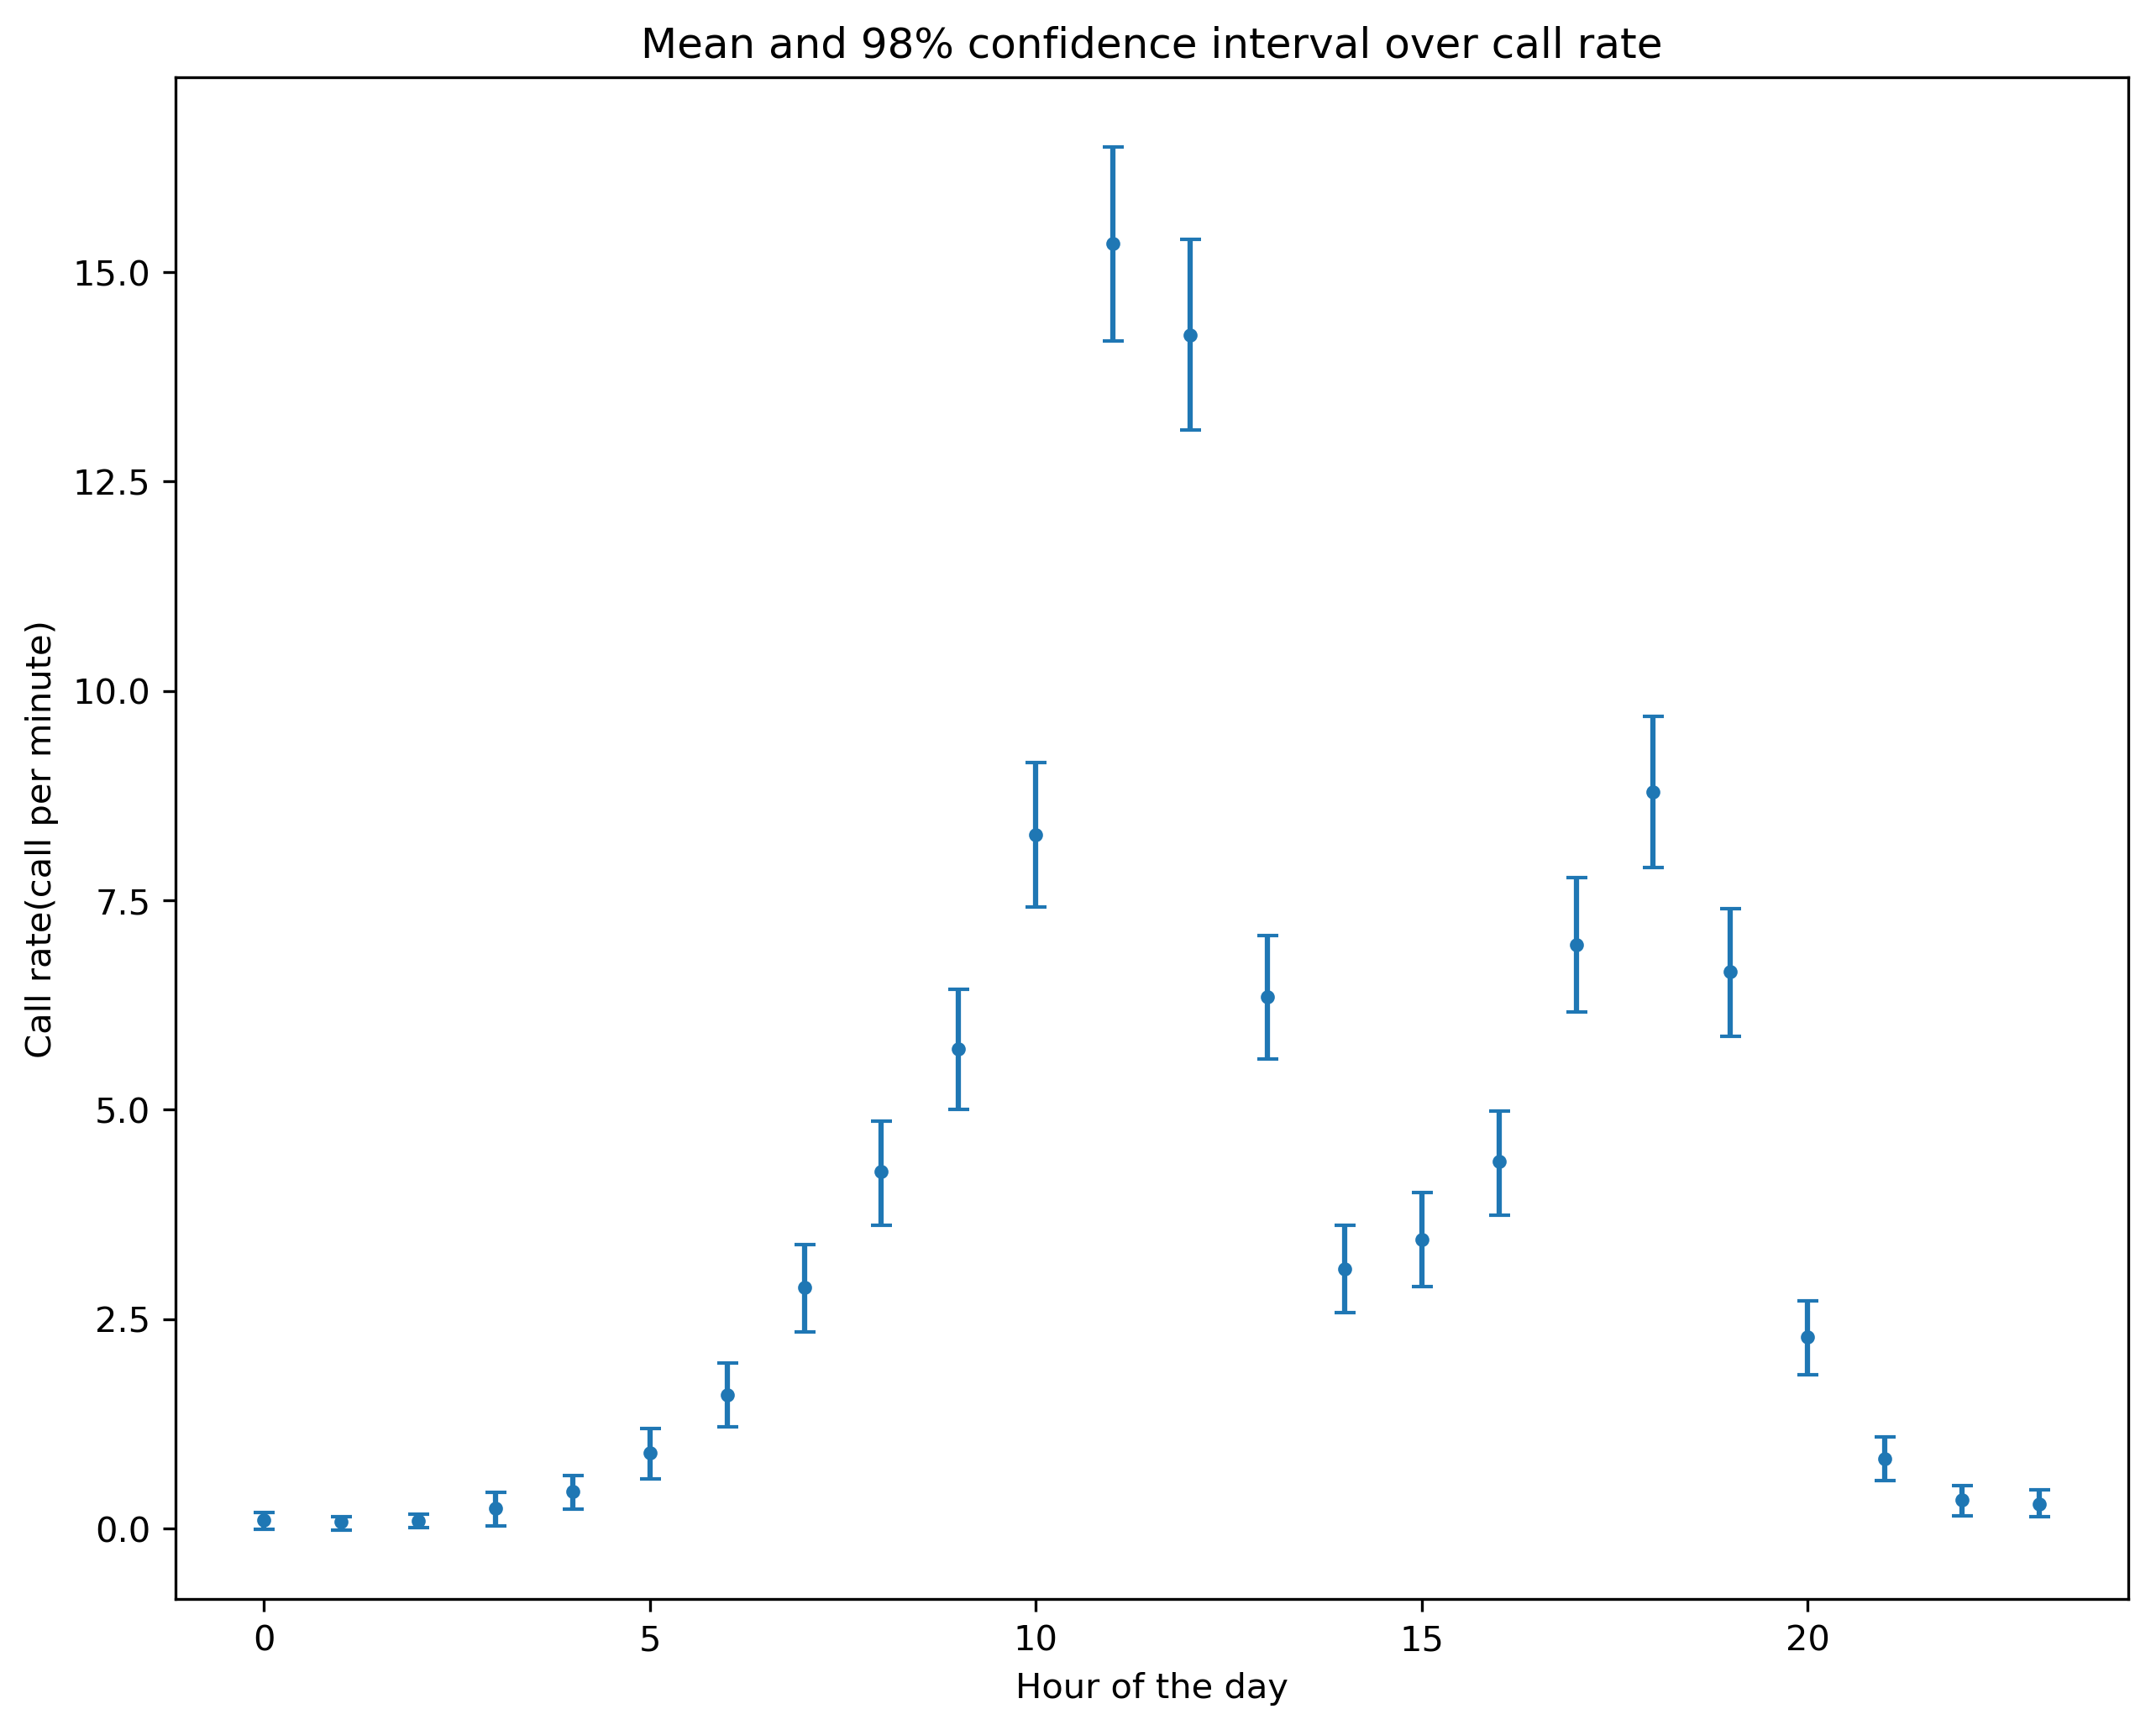

In [5]:
# Create empty lists for means and confidence intervals
mean_list=[]
confi_inv_list=[]

# Iterate the posterior calculated before to calculate their means and confidence intervals
for pos in pos_list:
    # Calculate the expected value of the posterior distribution as the mean
    mean_list.append(sp.integrate.trapz(pos*lambdas,lambdas))
    # Calculate the 98% confidence interval by knowing the 1% and 99% thresholds
    confi_inv_list.append([compute_percentile(lambdas,pos,0.01),compute_percentile(lambdas,pos,0.99)])

# Calculate the errors between the means and confidence intervals for plotting
error_list=[[],[]]
for i in range(len(mean_list)):
    error_list[0].append(confi_inv_list[i][0]-mean_list[i])
    error_list[1].append(mean_list[i]-confi_inv_list[i][1])

# Plot the results
plt.figure(figsize=(10,8),dpi = 300)
plt.errorbar(x=range(24),y=mean_list,yerr=error_list,fmt='.',capsize = 3)
plt.xlabel('Hour of the day')
plt.ylabel('Call rate(call per minute)')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()

### Paragraph to clients 

From the graph, we can observe the range of call rates of each hour of a day. The dots on the blue line segments presents the expected value of the call rates in a certain hour of the day. For example, at 11am, the call rate is around 15.5. Moreover, each blue line segment show th 98% confidence interval of the call rate in a certain hour. Simply put, the practical value of call rate at that hour is verly likely locates in the range shown. Therefore, to make sure we have enough telephone operator to get the call, we can set the call rate at the upper boundary of the confidence interval to calculate how many people we need each hour. For example, at 10am, the upper boundary is about 9, which means we have 9 calls per minute. Assume each telephone operator can get 1 call in 1 minute, we then need 9 people.

## Question2. Stretch goal 

1. In calculating the exponential functions, using original value can make the result too large or too small, which go beyond Python's calculation range. Therefore, we use logarithm to help us to do simple calculation. Since we know log(𝑎)+log(𝑏)=log(𝑎𝑏) and log(a)^b=blog(a), the calculation becomes much easier. The first line with "log_prior = np.log(prior(parameter_values))" turns the prior into log. The line "np.log(likelihood(param, data))" turns likelihood into log. The line "unnormalized_posterior = np.exp(unnormalized_log_posterior)" turns the log value back to the original value and outputs the result.
2. The sum function of logarithm of likelihoods actually did the original multiplication job of the original likelihoods, which can be presented in formula: 𝑃(𝑋|𝜆)=∏𝑛𝑖=1𝑃(𝑥𝑖|𝜆).
3. Since  log(𝑎)−log(𝑏)=log(𝑎/𝑏), it actually turns the original log value to a value in the range [0,1]. If we don't do this operation, the value can be very large, so that the result of np.exp(x) will go beyond Python's upper boundary of the value, thereby returning infinity(inf). After trails, I found that np.exp(800) arleady returns inf, and the actual code without that line has some values returning inf. Therefore, we turn the values into values in the range [0,1], and they will not return inf anymore.
4. Since line 7 didn't normalize the distribution, it actually did the job as I mentioned in 3, but has nothing to do with normalization. Only with line 10 that we divided by the area, we turn the sum of the area under the distribution as 1.
5. 

In [18]:

def compute_posterior_2(parameter_values, prior, likelihood, data):
    new_prior = prior(parameter_values)
    new_likelihood = np.array([10**10*(np.prod(likelihood(param, data))) for param in parameter_values])
    unnormalized_new_posterior = new_prior * new_likelihood
    unnormalized_new_posterior = unnormalized_new_posterior/max(unnormalized_new_posterior)
    area = sp.integrate.trapz(unnormalized_new_posterior, parameter_values)
    posterior = unnormalized_new_posterior / area
    return posterior

lambdas = np.linspace(0.01,24,600)
pos_list_2=[]

for calls in  waiting_times_per_hour:
    posterior = compute_posterior_2(lambdas, prior, likelihood, calls)
    pos_list_2.append(posterior)

plt.figure(figsize=(24,8))
for i in range(24):
    plt.plot(lambdas,pos_list_2[i],label=str(i+1)+":00")
plt.xticks(np.arange(0,20,3))
plt.yticks(np.arange(0,14,5))
plt.xlim(0,18)
plt.xlabel("Call rate $\lambda$")
plt.ylabel("Posterior probability density")
plt.legend(loc="best")
plt.show()


/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


KeyboardInterrupt: 

## Optional Exercises

### Question1

#### (a)

In [6]:
from scipy import stats
# Randomly generate 1000 values under normal distribution
generated=stats.norm.rvs(loc=100, scale=10,size=1000)
count=0
# Count the numbers that two stds away
for num in generated:
    if num>=100+2*10 or num<=100-2*10:
        count+=1
print("The count of generated values which are at least 2 std away from the mean is:",count)

The count of generated values which are at least 2 std away from the mean is: 56


The probability of a value being at least 2 std away from the mean is the sum of the integrals of the area from -infinity to 80 and from 120 to infinity, which is:
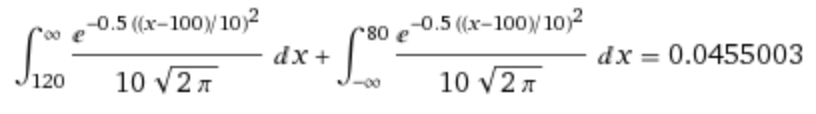

Therefore, the expected value is about 0.0455*1000=45.5.

In [7]:
# We can also calculate with Python
from scipy.integrate import quad

# Define the normal distribution
def normalProbabilityDensity(x):
    constant = 1.0 / (10*np.sqrt(2*np.pi))
    return(constant * np.exp((-((x-100)/10)**2) / 2.0) )

# Calculate the integral with quad function in stats library
print("The expected value(calculated by python) is:", 1000*2*quad(normalProbabilityDensity, np.NINF, 80)[0])

The expected value(calculated by python) is: 45.50026389636048


#### (b)

In [8]:
import numpy as np
head=0

# Count the heads(if choosing 1, then head)
for i in range(50):
    if np.random.choice([0,1])==1:
        head+=1
print("We finally get %i heads in 50 tosses." % head)

We finally get 29 heads in 50 tosses.


For a fair coin, the probability of getting a head is 50%. Therefore, the expected value is 50%*50=25.

#### (c)

In [9]:
sixs=0
# Count the number of 6s
for i in range(1000):
    if np.random.choice([1,2,3,4,5,6])==6:
        sixs+=1
print("We finally get %i 6s." % sixs)

We finally get 165 6s.


For a fair dice, the probability of getting a 6 is 1/6. Therefore, the expected value is 1/6*1000=166.67.

#### (d)

In [10]:
def normalProbabilityDensity(x):
    constant = 1.0 / (2*np.sqrt(2*np.pi))
    return(constant * np.exp((-(x/2)**2) / 2.0) )
print("The area to the right of 1.5 in the distribution is:", 1-quad(normalProbabilityDensity, np.NINF, 1.5)[0])

The area to the right of 1.5 in the distribution is: 0.22662735237686826


### Question2

#### (a)

In [11]:
# Randomly run "toss dice 1000 times" function 5000 times to record the result
result_list=[]
for a in range(5000):
    sixs=0
    for i in range(1000):
        if np.random.choice([1,2,3,4,5,6])==6:
            sixs+=1
    result_list.append(sixs)

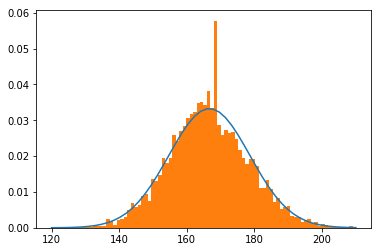

5% points: (165.9175186646814, 167.42248133531857)
25% points: (162.8463276324275, 170.4936723675725)
50% points: (158.57612299764702, 174.76387700235296)
75% points: (152.86580743548788, 180.4741925645121)
95% points: (143.15043218551935, 190.18956781448063)


In [12]:
# Guess the standard deviation of the normal distribution as 12(by observing the graph)
distribution = stats.norm(166.67, 12)
x = np.linspace(120, 210)
plt.plot(x, distribution.pdf(x))

# Plot the two graphs together to see the fit
plt.hist(result_list,bins=80,density=True)
plt.show()

# Print percentiles
print("5% points:",distribution.interval(0.05))
print("25% points:",distribution.interval(0.25))
print("50% points:",distribution.interval(0.50))
print("75% points:",distribution.interval(0.75))
print("95% points:",distribution.interval(0.95))